### Network Theory- Travelling Salesman Optimisation

In [24]:
# import packages
import pandas as pd
import numpy as np
from haversine import haversine
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.spatial.distance import pdist, squareform
from gurobipy import *

In [25]:
# opening the Djibouti data file in pandas dataframes:
# importing hw2 data into dataframe using pandas. 
djib = pd.read_table(("HW2_tsp.txt"), header=None, skiprows=10, sep=" ")

# dividing coordinates by 1,000
djib[[1,2]] = djib[[1,2]]/1000

#printing latitude and longitude for 38 cities in a country in Africa (Djibouti)
print (djib[[1,2]])

            1          2
0   11.003611  42.102500
1   11.108611  42.373889
2   11.133333  42.885833
3   11.155833  42.712500
4   11.183333  42.933333
5   11.297500  42.853333
6   11.310278  42.929444
7   11.416667  42.983333
8   11.423889  43.000278
9   11.438333  42.057222
10  11.461111  43.252778
11  11.485556  43.187222
12  11.503056  42.855278
13  11.511389  42.106389
14  11.522222  42.841944
15  11.569444  43.136667
16  11.583333  43.150000
17  11.595000  43.148056
18  11.600000  43.150000
19  11.690556  42.686667
20  11.715833  41.836111
21  11.751111  42.814444
22  11.770278  42.651944
23  11.785278  42.884444
24  11.822778  42.673611
25  11.846944  42.660556
26  11.963056  43.290556
27  11.973056  43.026111
28  12.058333  42.195556
29  12.149444  42.477500
30  12.286944  43.355556
31  12.300000  42.433333
32  12.355833  43.156389
33  12.363333  43.189167
34  12.372778  42.711389
35  12.386667  43.334722
36  12.421667  42.895556
37  12.645000  42.973333


In [26]:
# creating an array with distances between the destinations
# creating an empty numpy array
djdist = np.zeros((len(djib),len(djib)))

#running a loop to populate the array by calculating distances between provided coordinates
for i in range(0,len(djib)):
    for j in range(0,len(djib)):
        djdist[i,j] = haversine ((djib[1][i],djib[2][i]), (djib[1][j],djib[2][j]))

print (djdist)

[[   0.           31.83522548   86.6908608  ...,  204.0887048   179.77386272
   205.65378412]
 [  31.83522548    0.           55.92427526 ...,  176.45743266
   156.65956475  182.86683277]
 [  86.6908608    55.92427526    0.         ...,  147.68288928
   143.26004683  168.35907107]
 ..., 
 [ 204.0887048   176.45743266  147.68288928 ...,    0.           47.85168937
    48.62211181]
 [ 179.77386272  156.65956475  143.26004683 ...,   47.85168937    0.
    26.22933623]
 [ 205.65378412  182.86683277  168.35907107 ...,   48.62211181
    26.22933623    0.        ]]


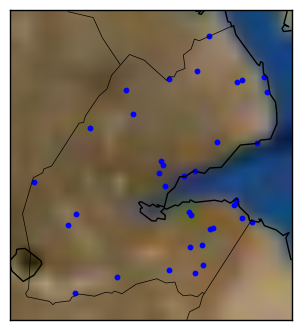

In [27]:
#building a map of destinations
djibmap = Basemap(width=200000,height=220000,projection='lcc', resolution='i',lat_0=11.824,lon_0=42.596)
djibmap.drawcoastlines(); djibmap.drawcountries(); 
djibmap.bluemarble()
xpt, ypt = djibmap(djib[2].values, djib[1].values)
djibmap.scatter(xpt,ypt,10,marker='o', color='b')
plt.show()

In [28]:
# Callback - use lazy constraints to eliminate sub-tours
def subtourelim(model, where):
  if where == GRB.callback.MIPSOL:
    selected = []
    # make a list of edges selected in the solution
    for i in range(len(djdist)):
      sol = model.cbGetSolution([model._vars[i,j] for j in range(len(djdist))])
      selected += [(i,j) for j in range(len(djdist)) if sol[j] > 0.5]
    # find the shortest cycle in the selected edge list
    tour = subtour(selected)
    if len(tour) < len(djdist):
      # add a subtour elimination constraint
      expr = 0
      for i in range(len(tour)):
        for j in range(i+1, len(tour)):
          expr += model._vars[tour[i], tour[j]]
      model.cbLazy(expr <= len(tour)-1)



In [29]:
# Given a list of edges, finds the shortest subtour
def subtour(edges):
  visited = [False]*len(djdist)
  cycles = []
  lengths = []
  selected = [[] for i in range(len(djdist))]
  for x,y in edges:
    selected[x].append(y)
  while True:
    current = visited.index(False)
    thiscycle = [current]
    while True:
      visited[current] = True
      neighbors = [x for x in selected[current] if not visited[x]]
      if len(neighbors) == 0:
        break
      current = neighbors[0]
      thiscycle.append(current)
    cycles.append(thiscycle)
    lengths.append(len(thiscycle))
    if sum(lengths) == len(djdist):
      break
  return cycles[lengths.index(min(lengths))]

m = Model()

# Create variables
vars = {}
for i in range(len(djdist)):
   for j in range(i+1):
     vars[i,j] = m.addVar(obj=djdist[i,j], vtype=GRB.BINARY,
                          name='e'+str(i)+'_'+str(j))
     vars[j,i] = vars[i,j]
   m.update()

In [30]:
# Add degree-2 constraint, and forbid loops
for i in range(len(djdist)):
  m.addConstr(quicksum(vars[i,j] for j in range(len(djdist))) == 2)
  vars[i,i].ub = 0

m.update()

In [31]:
# Optimize model
m._vars = vars
m.params.LazyConstraints = 1
m.optimize(subtourelim)

solution = m.getAttr('x', vars) # producing list of solutions
selected = [(i,j) for i in range(len(djdist)) for j in range(len(djdist)) if solution[i,j] > 0.5] #producing list of selected nodes from the solutions

Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 38 rows, 741 columns and 1444 nonzeros
Variable types: 0 continuous, 741 integer (741 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 3384.58
Presolve removed 0 rows and 38 columns
Presolve time: 0.00s
Presolved: 38 rows, 703 columns, 1406 nonzeros
Variable types: 0 continuous, 703 integer (703 binary)

Root relaxation: objective 6.993573e+02, 49 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  699.35728    0   10 3384.57839  699.35728  79.3%     -    0s
H    0     0                     854.9674757  699.35728  18.2%     -    0s
H    0     0                     851.7101507  699.35728  17

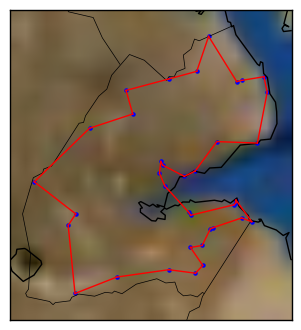

In [32]:
#building a map of destinations and the shortest path tour as calculated using Gurobi
djibmap = Basemap(width=200000,height=220000,projection='lcc', resolution='i',lat_0=11.824,lon_0=42.596)
djibmap.drawcoastlines(); djibmap.drawcountries(); 
djibmap.bluemarble()
xpt, ypt = djibmap(djib[2].values, djib[1].values)
djibmap.scatter(xpt,ypt,5,marker='o', color='b')
for n in range (len(selected)):
    if selected[n][0]<selected[n][1]:    
        node1= selected[n][0]; node2= selected[n][1]
        djibmap.drawgreatcircle(djib[2][node1],djib[1][node1], djib[2][node2],djib[1][node2], linewidth=1,color='r')
plt.show()

In [33]:
#printing a sequence of nodes (locations) of the tour 
tsptour=[0]; k=0
while k < (len(selected)/2-1): 
    for n in range(len(selected)):        
        if (selected[n][0]==tsptour[-1] and
        selected[n][1] not in tsptour):
            tsptour.append(selected[n][1])
            k+=1

In [34]:
print (tsptour)

[0, 1, 3, 2, 4, 5, 6, 7, 8, 11, 10, 18, 17, 16, 15, 12, 14, 19, 22, 25, 24, 21, 23, 27, 26, 30, 35, 33, 32, 37, 36, 34, 31, 29, 28, 20, 13, 9]
